<a href="https://colab.research.google.com/github/subhajitphy/eWGB/blob/main/right_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
inp1,inp2,outp=np.load('all_file_nef.pkl', allow_pickle=True)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
X = np.vstack([inp1, inp2]).T
y = outp.reshape(-1, 1)  # Ensure y is a column vector

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize Input & Output
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

In [ ]:
# Create DataLoader
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class EfficientNN(nn.Module):
    def __init__(self):
        super(EfficientNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 40),
            nn.BatchNorm1d(40),  # Batch Normalization
            nn.ReLU(),

            nn.Linear(40, 40),
            nn.BatchNorm1d(40),
            nn.ReLU(),

            nn.Linear(40, 40),
            nn.BatchNorm1d(40),
            nn.ReLU(),

            nn.Linear(40, 40),
            nn.BatchNorm1d(40),
            nn.ReLU(),

            nn.Linear(40, 40),
            nn.BatchNorm1d(40),
            nn.ReLU(),

            nn.Linear(40, 40),
            nn.BatchNorm1d(40),
            nn.ReLU(),

            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Instantiate the model
model = EfficientNN()

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# # Example Training Loop
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


In [ ]:
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_loss:.6f}")

Epoch 1/20, Train Loss: 0.007331, Val Loss: 0.000246
Epoch 2/20, Train Loss: 0.001931, Val Loss: 0.000175
Epoch 3/20, Train Loss: 0.001922, Val Loss: 0.000308
Epoch 4/20, Train Loss: 0.001829, Val Loss: 0.000207
Epoch 5/20, Train Loss: 0.001852, Val Loss: 0.000705
Epoch 6/20, Train Loss: 0.001527, Val Loss: 0.000242
Epoch 7/20, Train Loss: 0.001565, Val Loss: 0.000252
Epoch 8/20, Train Loss: 0.001364, Val Loss: 0.000118
Epoch 9/20, Train Loss: 0.001444, Val Loss: 0.000488
Epoch 10/20, Train Loss: 0.001426, Val Loss: 0.000244
Epoch 11/20, Train Loss: 0.001151, Val Loss: 0.000199
Epoch 12/20, Train Loss: 0.001103, Val Loss: 0.000164
Epoch 13/20, Train Loss: 0.001068, Val Loss: 0.000097
Epoch 14/20, Train Loss: 0.001018, Val Loss: 0.000064
Epoch 15/20, Train Loss: 0.001011, Val Loss: 0.000155
Epoch 16/20, Train Loss: 0.000899, Val Loss: 0.000154
Epoch 17/20, Train Loss: 0.000830, Val Loss: 0.000056
Epoch 18/20, Train Loss: 0.000763, Val Loss: 0.000072
Epoch 19/20, Train Loss: 0.000722, Va

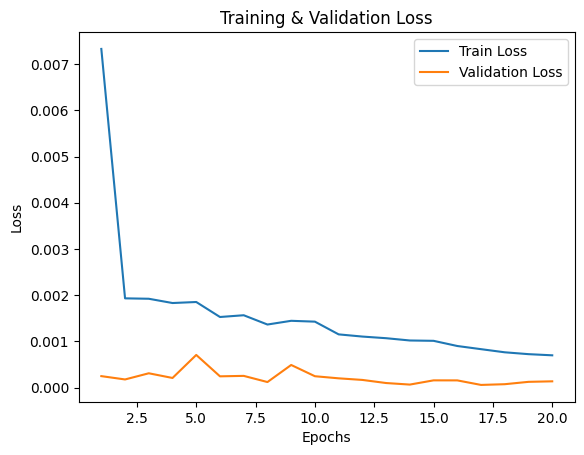

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), "trained_model.pth")

# Inference (prediction)
def predict(inp_array):
    model.eval()
    inp_tensor = torch.tensor(inp_array, dtype=torch.float32)
    with torch.no_grad():
        return model(inp_tensor).numpy()

# Example prediction
test_input = np.array([[-8.5, 1.1]])  # Example input
print("Predicted output:", predict(test_input))

Predicted output: [[-4.461468]]


In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# You may want to inverse transform the predicted and actual values back to their original scale
predictions = scaler_y.inverse_transform(predictions.numpy())
y_test = scaler_y.inverse_transform(y_test_tensor.numpy())

In [ ]:
predictions-y_test

array([[-0.01409817],
       [-0.00997162],
       [ 0.00881481],
       ...,
       [-0.01936626],
       [-0.00124073],
       [-0.00556231]], dtype=float32)

In [ ]:
X_test_tensor.shape

torch.Size([200000, 2])

In [ ]:
X_test_tensor

tensor([[ 1.6731,  0.6376],
        [-1.1266, -0.8262],
        [ 0.0234,  1.1618],
        ...,
        [ 1.5591, -0.6687],
        [-0.1152, -0.4264],
        [ 1.1928,  1.6564]])

In [ ]:
def predict(new_inputs):
        """
        Predict outputs for new input data

        Parameters:
        new_inputs (np.array): 2D array of shape (n_samples, 2)

        Returns:
        np.array: Predicted outputs in original scale
        """
        model.eval()
        if len(new_inputs.shape) == 1:
            new_inputs = new_inputs.reshape(1, -1)

        if new_inputs.shape[1] != 2:
            raise ValueError("Input must have 2 features")

        inputs_scaled = scaler_X.transform(new_inputs)
        inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32).to(device)

        with torch.no_grad():
            pred_scaled = model(inputs_tensor)

        pred = scaler_y.inverse_transform(pred_scaled.cpu().numpy())
        return pred.flatten()

In [ ]:
predict(np.array([-9,1.9]))

array([-9.4551735], dtype=float32)